In [ ]:
# This notebook heavily uses the publicly available codes from
#https://github.com/POSTECH-CVLab/PyTorch-StudioGAN.git
#for GAN model and Langevin sampling
#https://github.com/mseitzer/pytorch-fid.git
#for FID evaluation

In [1]:
import os
import numpy as np

import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.distributions.multivariate_normal as MN
from torch.distributions import Normal, Independent, Uniform

import matplotlib.pyplot as plt

from tqdm import tqdm

import time
import random
#imports below are required for running the code in the notebook
#modules for these imports can be found on the githab in folder image_data
import mainer
import utils.losses as losses
import pytorch_fid.fid_score as fidscore

C:\conda3_07\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
seed = 1337
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [4]:
#configure SNGAN generator and discriminator 
#SNGAN and weights from https://github.com/POSTECH-CVLab/PyTorch-StudioGAN.git
netG, netD = mainer.mainer()

#load pretrained weights
G_weights = torch.load("sngan_weights/model=G-best-weights-step=90000.pth")
D_weights = torch.load("sngan_weights/model=D-best-weights-step=90000.pth")

netG.load_state_dict(G_weights["state_dict"])
netD.load_state_dict(D_weights["state_dict"])

<All keys matched successfully>

In [5]:
netG = netG.to(device)
netD = netD.to(device)

In [44]:
#just to check how much memory is required to store G and D
!nvidia-smi

Tue Dec 21 04:26:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.06       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     1W /  N/A |   1914MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
#function for saving images 
#by default the images are stored in ```generated``` subfolder of the project folder
def save_imgs(inp, it=None, last_number=None, dir_result_save="generated"):    
    transform_inv = torchvision.transforms.Compose([torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2))])
    output = transform_inv(inp).numpy().transpose((0, 2, 3, 1))
    
    if it is not None:
        path = "/".join((dir_result_save, f"{it}"))
    else:
        path = dir_result_save
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    for j in range(output.shape[0]):
        name = j
        if last_number is not None:
            name += last_number+1
        fileset = {'name': name,
                   'output': "%04d-output.png" % name}
        plt.imsave(os.path.join(path, fileset['output']), output[j, :, :, :].squeeze())

In [7]:
#Langevin sampling from StudioGAN
#https://github.com/POSTECH-CVLab/PyTorch-StudioGAN.git

def langevin_sampling(zs, z_dim, fake_labels, generator, discriminator, batch_size, 
                      langevin_rate=0.01, langevin_noise_std=0.1,
                      langevin_decay=0, langevin_decay_steps=0, 
                      langevin_steps=500, device="cuda:0", 
                      store_prev=False, each_it_save=0):
    #decay for Langevin step, we don't use it in our experiments
    scaler = 1.0
    apply_decay = langevin_decay > 0 and langevin_decay_steps > 0
    
    #prior distribution initialization
    mean = torch.zeros(z_dim, device=device)
    prior_std = torch.eye(z_dim, device=device)
    lgv_std = prior_std * langevin_noise_std
    prior = MN.MultivariateNormal(loc=mean, covariance_matrix=prior_std)
    
    #if we want to store the progress of sampling
    if store_prev:
        history = [zs.clone()]
    
    #Gaussain noise initialization
    lgv_prior = MN.MultivariateNormal(loc=mean, covariance_matrix=lgv_std)
    for i in tqdm(range(langevin_steps)):
        zs = autograd.Variable(zs, requires_grad=True)
        #generate GAN part of energy
        fake_images = generator(zs, fake_labels, eval=True)
        fake_dict = discriminator(fake_images, fake_labels, eval=True)

        #compute energy
        energy = -prior.log_prob(zs) - fake_dict["adv_output"]
        #compute grad of the energy w.r.t its input
        z_grads = losses.cal_deriv(inputs=zs, outputs=energy, device=device)

        #update latent code
        zs = zs - 0.5 * langevin_rate * z_grads + (langevin_rate**0.5) * lgv_prior.sample([batch_size]) * scaler
        
        if apply_decay and (i + 1) % langevin_decay_steps == 0:
            langevin_rate *= langevin_decay
            scaler *= langevin_decay
            
        #if we store the progress of sampling
        if store_prev and i % each_it_save==0:
            history.append(zs.clone())
    
    if store_prev:
        return torch.stack(history, dim=0)
    else:
        return zs

In [8]:
#here one of the first DDLS tests was run
batch_size = 50
num_batches = 1
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)

all_pics = []
for i in range(num_batches):
    zs = diagn.sample([batch_size]).to(device)
    y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                       dtype=torch.long, device=device)
    latent_tuned = langevin_sampling(zs, z_dim, y_fake, netG, netD, batch_size)
    all_pics.append(latent_tuned.detach().cpu())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:54<00:00,  4.38it/s]


In [41]:
#function to plot generated images 
def imshow(img, fsize=20, title="", name="change.png", figsize=(12,12)):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, axs = plt.subplots(figsize=figsize)
    axs.imshow(np.transpose(npimg, (1, 2, 0)))
    axs.set_title(title, y=-0.05, fontsize=fsize)
    plt.axis('off')
    plt.savefig(name)

In [45]:
#this cell generated images from SNGAN without DDLS
#we need this to compute FID between them and CIFAR10
#in total 10000 images are generated to accumulate enough statistics about the data

batch_size = 50
num_batches = 200
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)

all_pics = []

for i in range(num_batches):
    zs = diagn.sample([batch_size]).to(device)
    y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                       dtype=torch.long, device=device)
    vanil_img = netG(zs, y_fake, eval=True)
    all_pics.append(vanil_img.detach().cpu())
    
all_pics = torch.stack(all_pics, dim=0)
all_pics = all_pics.view(-1, 3, 32, 32)
#images are saved into ```vanilla``` subfolder
save_imgs(all_pics, dir_result_save="vanilla")

In [ ]:
#THIS CELL WAS RUN IN COLAB FOR FASTER LATENT CODES GENERATION VIA DDLS
batch_size = 200
num_batches = 30
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)

all_pics = []
for i in range(num_batches):
    zs = diagn.sample([batch_size]).to(device)
    y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                       dtype=torch.long, device=device)
    latent_tuned = langevin_sampling(zs, z_dim, y_fake, netG, netD, 
                                     batch_size, langevin_steps=1000)
    all_pics.append(latent_tuned.detach().cpu())
    
all_pics = torch.stack(all_pics, dim=0)
all_pics = all_pics.view(-1, 128).detach().cpu().numpy()
np.save("1000_its_enh.npy", all_pics)

In [ ]:
#images are generated here from DDLS latent codes
img_np = np.load("1000_its_enh.npy")
#the file itself was lost somewhere during experiments
#but the generated images are still on my pc
#you can also find them here
#https://drive.google.com/drive/folders/1SVuDTggbGFC2baXmnkm5F-KNgzgw3ER4?usp=sharing

batch_size = 50
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)


imgs = []
for i in range(img_np.shape[0] // batch_size):
    tens = torch.tensor(img_np[i:i+batch_size])
    y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                           dtype=torch.long, device=device)
    enh_imgs = netG(tens.to(device), y_fake, eval=True)
    imgs.append(enh_imgs.detach().cpu())
    
all_pics = torch.stack(imgs, dim=0)
all_pics = all_pics.view(-1, 3, 32, 32)
#images are saved into ```enhanced``` subfolder
save_imgs(all_pics, dir_result_save="enhanced")

In [ ]:
#THIS CELL WAS RUN IN COLAB FOR FASTER LATENT CODES GENERATION VIA DDLS
#ON LOCAL MACHINE FILE 500_epoch_imgs.npy WITH GENERATED DDLS LATENT CODES WAS LOADED
batch_size = 20
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)

all_pics = []
zs = diagn.sample([batch_size]).to(device)
y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                       dtype=torch.long, device=device)
latent_tuned = langevin_sampling(zs, z_dim, y_fake, netG, netD, batch_size, 
                                 store_prev=True, each_it_save=25)
all_pics.append(latent_tuned.detach().cpu())
story_gen = all_pics[0].numpy()
np.save("500_epoch_imgs.npy", story_gen)

In [10]:
#images are generated here from DDLS latent codes
img_np = np.load("500_epoch_imgs.npy")

batch_size = 50
z_dim = 128

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)


imgs = []
for i in range(img_np.shape[0] // batch_size):
    tens = torch.tensor(img_np[i:i+batch_size])
    y_fake = torch.randint(low=0, high=8, size=(batch_size, ),
                           dtype=torch.long, device=device)
    enh_imgs = netG(tens.to(device), y_fake, eval=True)
    imgs.append(enh_imgs.detach().cpu())

In [25]:
t_imgs = torch.stack(imgs, dim=1)
t_imgs = t_imgs.view(-1, 3, 32, 32)

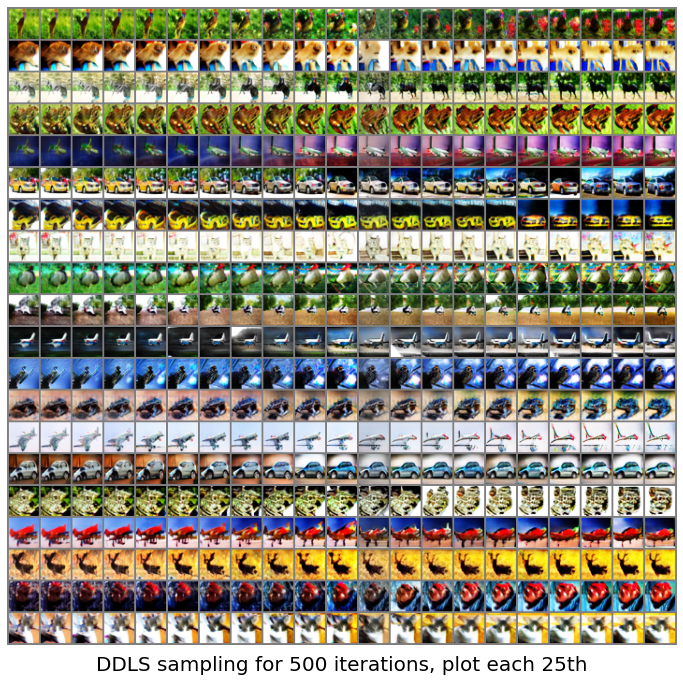

In [43]:
#here we look at what we obtained
imshow(torchvision.utils.make_grid(t_imgs, nrow=21), title="DDLS sampling for 500 iterations, plot each 25th")

To calculate FID the folder with images of CIFAR10 is required.

I stored these images in the folder ```cifar\\train``` in the same folder with the project

In [5]:
gen_path = "C:\\Users\\anton\\Documents\\SkCourses\\AppliedStatistics\\proj2"
cif_pth = "cifar\\train"
path_cif = "\\".join((gen_path, cif_pth))

In [4]:
#here is the FID for CIFAR10 and generated images by DDLS
#the FID score is calculated with code from
#https://github.com/mseitzer/pytorch-fid.git
gen_pth = "enhanced"
path_gen = "\\".join((gen_path, gen_pth))

score0, stat_cif, _ = fidscore.find_fid([path_cif, path_gen])
#the statistic for CIFAR10 is saved to save time for further FID evaluation
np.save("cif_mean.npy", stat_cif[0].detach().cpu().numpy())
np.save("cif_cov.npy", stat_cif[1].detach().cpu().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:45<00:00,  1.33it/s]


FID:  33.13395585226186


In [3]:
stat_cif = (np.load("cif_mean.npy"), np.load("cif_cov.npy"))

In [6]:
#here is the FID for CIFAR10 and generated images by simple SNGAN
vanilla_path = "\\".join((gen_path, "vanilla"))
score_vanilla, _, _ = fidscore.find_fid([path_cif, vanilla_path], stat_orig=stat_cif)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


FID:  19.309513588008997
